In [1]:
%load_ext autoreload
%autoreload 2

%pylab inline

from models import *
from utils import load_dataset, training_steps, evaluation_step
import yaml
import torch
from torch.utils.data import DataLoader
import math
import torchvision

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
BS = 64
BS_test = 1000
with open('./parameters/VAE_MNIST.yaml', 'rb') as f:
    config = yaml.safe_load(f)

data, unnormalize, nb_classes = load_dataset(config)
dataloader = DataLoader(data, batch_size = BS, shuffle = True)
img_shape = dataloader.dataset[0][0].shape

test_data, _, _ = load_dataset(config, training = False)
test_dataloader = DataLoader(test_data, batch_size = BS_test, shuffle = True)


In [3]:
batch, label = next(iter(test_dataloader))
batch = batch.to(device)

# VAE 3D

In [11]:
vae = VAE_3D(config, dataloader.dataset[0][0].shape, nb_classes)

vae = vae.to(device)

VAE epoch: 19.000 Loss: 4.801: 100%|██████████| 938/938 [00:29<00:00, 31.44it/s]


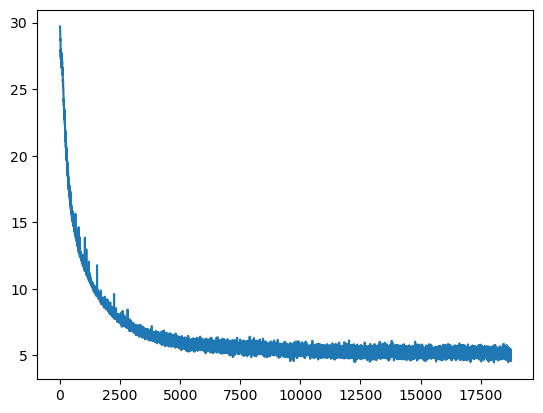

In [12]:
losses = training_steps(vae, dataloader,unnormalize)
plot(losses)

In [14]:
batch, label = next(iter(test_dataloader))
batch = batch.to(device)
vae.eval()
with torch.no_grad():
    out = vae(batch)
    loss_dict = vae.loss_function(out, batch, unnormalize)
loss_dict['loss'].item(), loss_dict['kl_loss'].mean().item() 

(5.193177223205566, 3.1492738723754883)

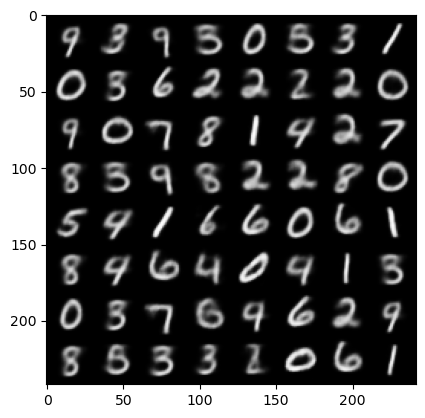

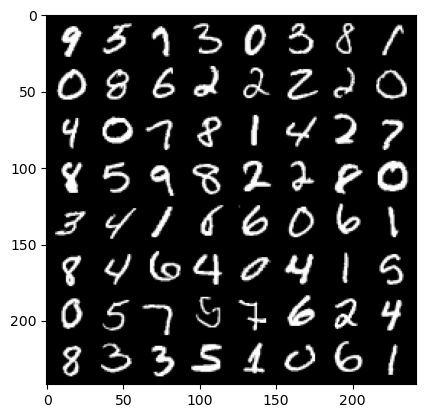

In [15]:
imshow(torchvision.utils.make_grid(unnormalize(out[0][:BS]).cpu(), nrow = int(math.sqrt(BS))).permute(1,2,0))
show()
imshow(torchvision.utils.make_grid(unnormalize(batch[:BS]).cpu(), nrow = int(math.sqrt(BS))).permute(1,2,0))

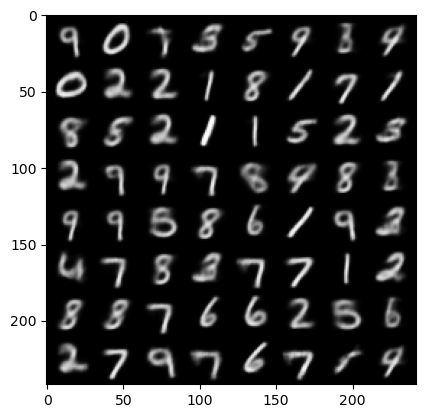

In [16]:
img_sampled = vae.sample(BS)
imshow(torchvision.utils.make_grid(unnormalize(img_sampled).cpu(), nrow = int(math.sqrt(BS))).permute(1,2,0))

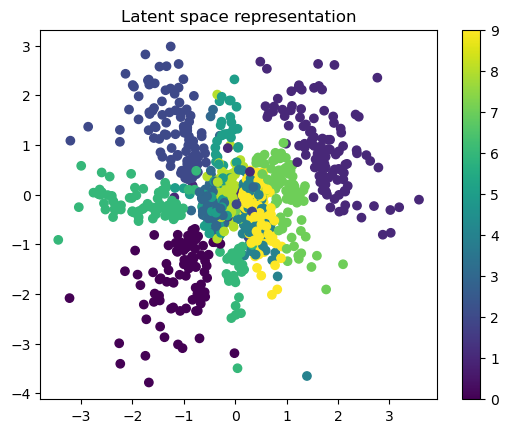

In [17]:
with torch.no_grad():
    mu, logvar = vae.encoder(batch.to(device))
    z = vae.reparameterize(mu, logvar).cpu().detach()
scatter(z[:,0], z[:,1], c= list(label.numpy()), cmap = 'viridis')
title('Latent space representation')
colorbar()

# VAE complex

VAE epoch: 9.000 Loss: 6.495: 100%|██████████| 938/938 [00:54<00:00, 17.31it/s]


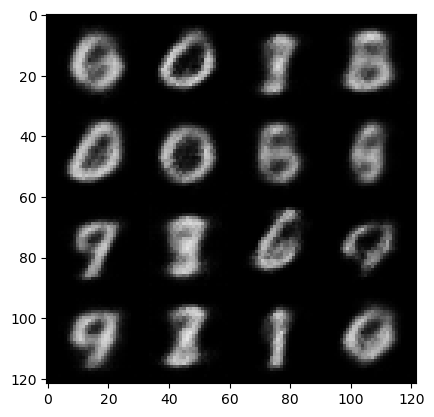

VAE epoch: 19.000 Loss: 5.741: 100%|██████████| 938/938 [00:51<00:00, 18.05it/s]


In [16]:
with open('./parameters/VAEcomplex_MNIST_params.yaml', 'rb') as f:
    config_complex = yaml.safe_load(f)
vae_complex = VAE_complex(config_complex, dataloader.dataset[0][0].shape, nb_classes)
vae_complex.to(device)
losses_complex = training_steps(vae_complex,dataloader, unnormalize, plots = 10)

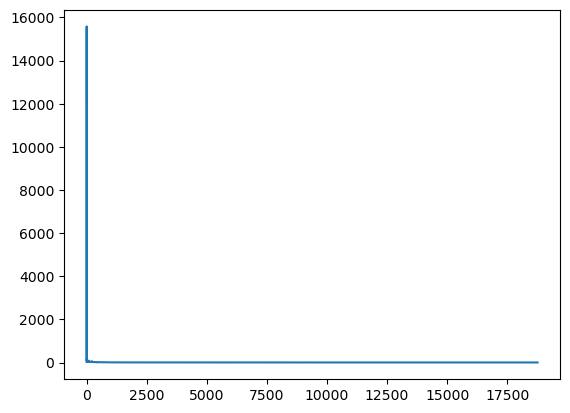

In [17]:
plot(losses_complex)

In [18]:
batch, label = next(iter(test_dataloader))
batch = batch.to(device)
vae_complex.eval()
with torch.no_grad():
    out = vae_complex(batch)

    loss_dict = vae_complex.loss_function(out, batch, unnormalize)
loss_dict['loss'].item(), loss_dict['kl_loss'].mean().item()

(5.785782337188721, 1.154740333557129)

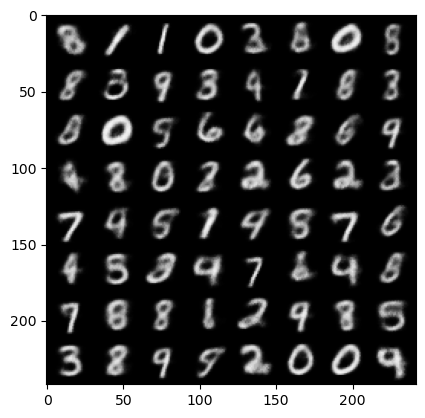

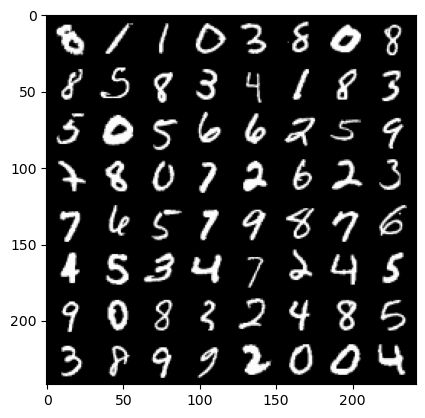

In [19]:
imshow(torchvision.utils.make_grid(unnormalize(out[0][:BS]).cpu(), int(math.sqrt(BS))).permute(1,2,0))
show()
imshow(torchvision.utils.make_grid(unnormalize(batch[:BS]).cpu(), int(math.sqrt(BS))).permute(1,2,0))


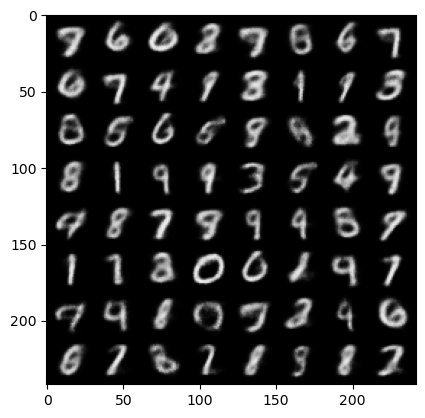

In [20]:
img_complex_samp = vae_complex.sample(BS)
imshow(torchvision.utils.make_grid(unnormalize(img_complex_samp).cpu(), nrow = int(math.sqrt(BS))).permute(1,2,0))

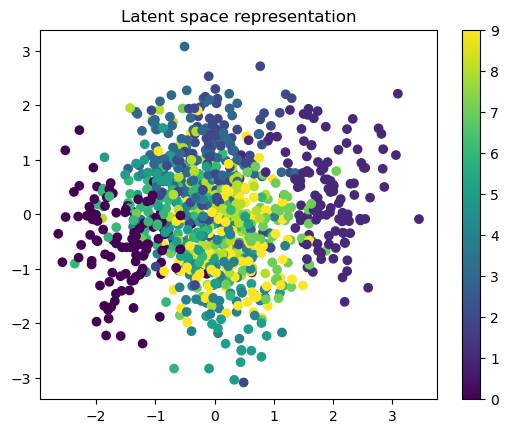

In [21]:
with torch.no_grad():
    mu, logvar = vae_complex.encoder(batch)
    z = vae_complex.reparameterize(mu, logvar).cpu().detach()
scatter(z[:,0], z[:,1], c= list(label.numpy()), cmap = 'viridis')
title('Latent space representation')
colorbar()

# Multi-Stage VAE

VAE epoch: 4.000 Loss: 6.784: 100%|██████████| 938/938 [00:32<00:00, 28.81it/s]


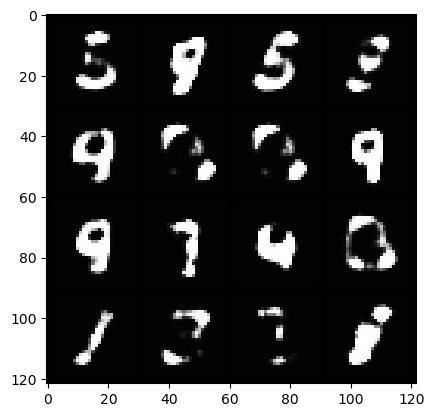

VAE epoch: 9.000 Loss: 6.029: 100%|██████████| 938/938 [00:32<00:00, 28.98it/s]


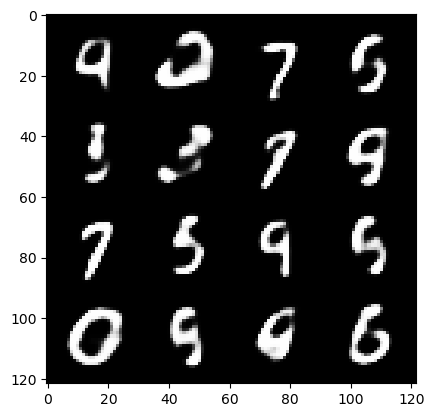

VAE epoch: 14.000 Loss: 6.450: 100%|██████████| 938/938 [00:32<00:00, 29.29it/s]


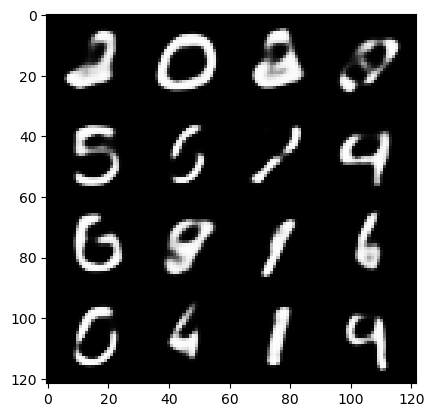

VAE epoch: 19.000 Loss: 6.358: 100%|██████████| 938/938 [00:32<00:00, 28.78it/s]


In [57]:
with open('./parameters/MultiStageVAE_MNIST.yaml', 'rb') as f:
    config_multi = yaml.safe_load(f)
multi_vae = MultiStage_VAE(config_multi, dataloader.dataset[0][0].shape, nb_classes)
multi_vae.to(device)
losses_multi = training_steps(multi_vae,dataloader, unnormalize, plots = 5)

In [58]:
batch = next(iter(test_dataloader))[0].to(device)
multi_vae.eval()
with torch.no_grad():
    out = multi_vae(batch)
    loss_dict = multi_vae.loss_function(out, batch, unnormalize)
loss_dict['loss'].item(), loss_dict['kl_loss'].mean().item()

(6.063673973083496, 1.138885498046875)

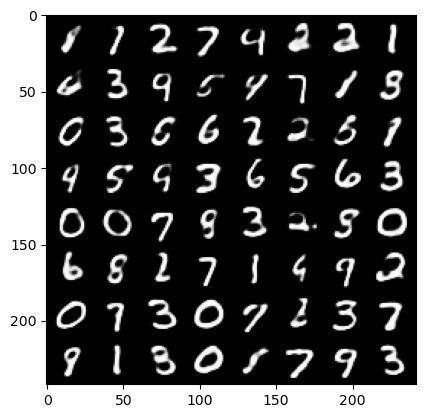

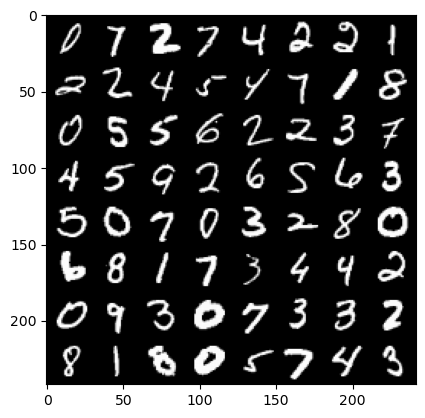

In [59]:
imshow(torchvision.utils.make_grid(unnormalize(out[0][:BS]).cpu(), int(math.sqrt(BS))).permute(1,2,0))
show()
imshow(torchvision.utils.make_grid(unnormalize(batch[:BS]).cpu(), int(math.sqrt(BS))).permute(1,2,0))


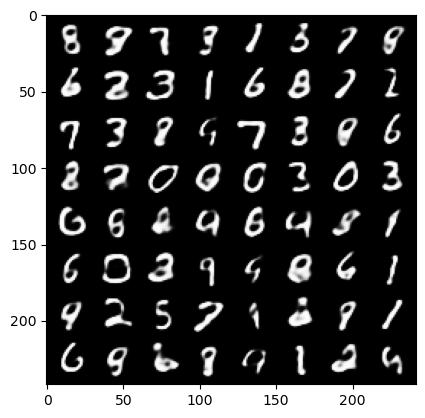

In [63]:
multi_img_samp = multi_vae.sample(BS)
imshow(torchvision.utils.make_grid(unnormalize(multi_img_samp).cpu(), int(math.sqrt(BS))).permute(1,2,0))


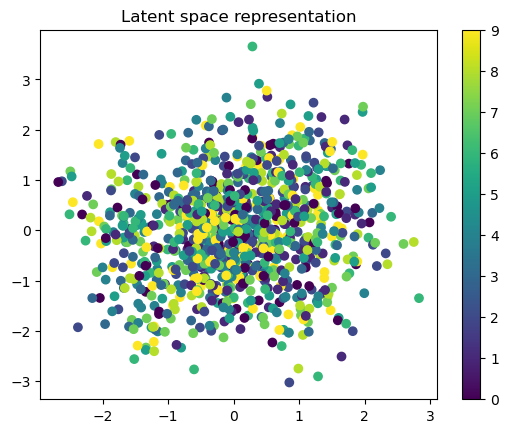

In [62]:
with torch.no_grad():
    mu, logvar = multi_vae.encoder(batch)
    z = multi_vae.reparameterize(mu, logvar).cpu().detach()
scatter(z[:,0], z[:,1], c= list(label.numpy()), cmap = 'viridis')
title('Latent space representation')
colorbar()
show()

# VQ-VAE

### PixelCNN latent generator

In [74]:
with open('./parameters/VQVAE_MNIST.yaml') as f:
    config_vqvae = yaml.safe_load(f)

vq_vae = VQ_VAE(config_vqvae, dataloader.dataset[0][0].shape, nb_classes)
vq_vae = vq_vae.to(device)
losses_vqvae = training_steps(vq_vae, dataloader, unnormalize)

Generator epoch: 9.0, loss: 0.780: 100%|██████████| 938/938 [00:15<00:00, 59.35it/s]


In [75]:
vq_vae.eval()
with torch.no_grad():
    out = vq_vae(batch)
    loss_dict = vq_vae.loss_function(out, batch, unnormalize)
loss_dict['loss'].item(), loss_dict['commitment_loss'].item()*vq_vae.optim_params['commitment_weight']

(0.18900609016418457, 0.02517448961734772)

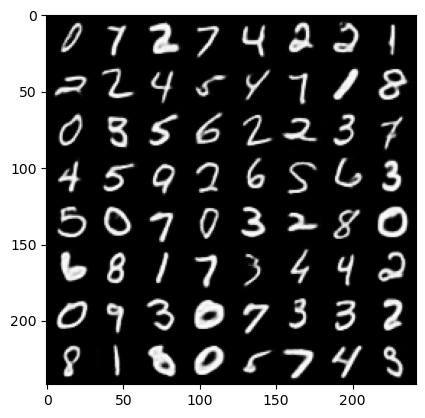

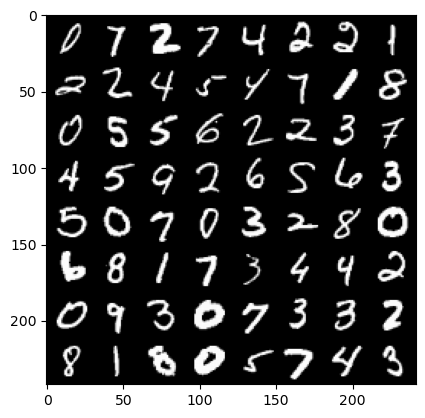

In [76]:
imshow(torchvision.utils.make_grid(unnormalize(out[0][:BS]).cpu()).permute(1,2,0))
show()
imshow(torchvision.utils.make_grid(unnormalize(batch[:BS]).cpu()).permute(1,2,0))

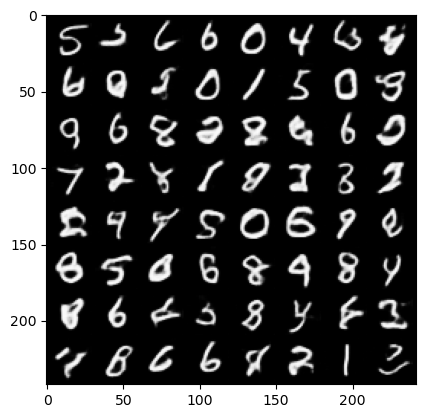

In [77]:
vqvae_sample = vq_vae.sample(BS)
imshow(torchvision.utils.make_grid(unnormalize(vqvae_sample).cpu(), int(math.sqrt(BS))).permute(1,2,0))


### LSTM latent generator

In [78]:
with open('./parameters/VQVAE_MNIST_LSTMprior.yaml') as f:
    config_vqvae_lstm = yaml.safe_load(f)

vq_vae_lstm = VQ_VAE(config_vqvae_lstm, dataloader.dataset[0][0].shape, nb_classes)
vq_vae_lstm = vq_vae_lstm.to(device)
losses_vqvae_lstm = training_steps(vq_vae_lstm, dataloader, unnormalize)

Generator epoch: 9.0, loss: 0.593: 100%|██████████| 3443/3443 [00:31<00:00, 108.06it/s]


In [79]:
vq_vae_lstm.eval()
with torch.no_grad():
    out = vq_vae_lstm(batch)
    loss_dict = vq_vae_lstm.loss_function(out, batch, unnormalize)
loss_dict

{'loss': tensor(0.1902, device='cuda:0'),
 'recon_loss': tensor(0.0403, device='cuda:0'),
 'commitment_loss': tensor(0.1249, device='cuda:0'),
 'embed_loss': tensor(0.1249, device='cuda:0')}

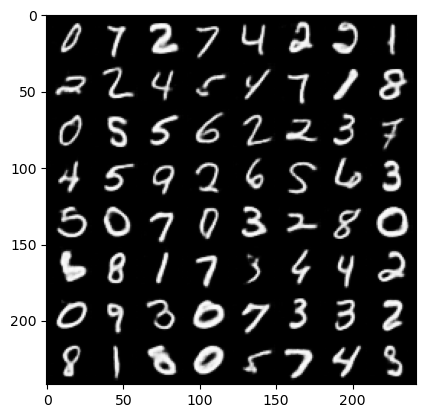

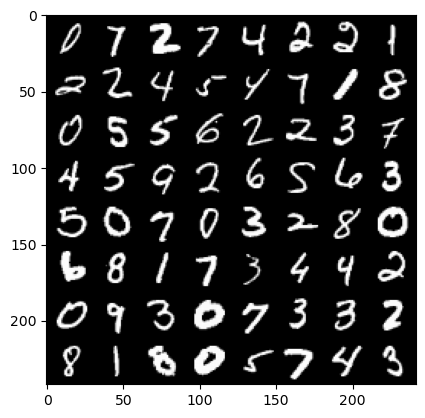

In [80]:
imshow(torchvision.utils.make_grid(unnormalize(out[0][:BS])).cpu().permute(1,2,0))
show()
imshow(torchvision.utils.make_grid(unnormalize(batch[:BS])).cpu().permute(1,2,0))

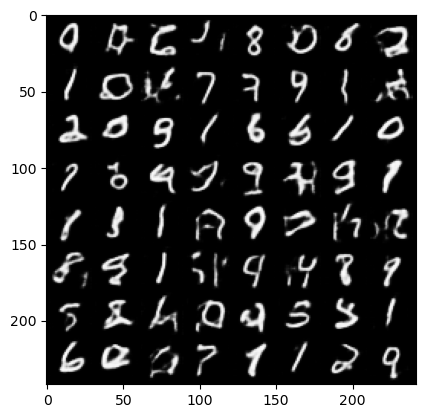

In [81]:
vqvae_lstm_sample = vq_vae_lstm.sample(BS)
imshow(torchvision.utils.make_grid(unnormalize(vqvae_lstm_sample).cpu()).permute(1,2,0))

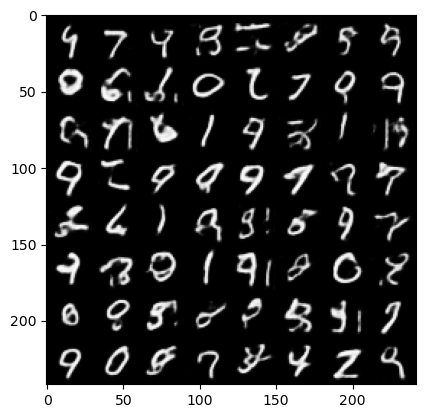

In [82]:
img = vq_vae_lstm.sample(BS)
imshow(torchvision.utils.make_grid(unnormalize(img).cpu()).permute(1,2,0))

# GAN

In [15]:
with open('./parameters/GAN_MNIST_params.yaml', 'rb') as f:
    config_gan = yaml.safe_load(f)

gan = GAN(config_gan, img_shape, nb_classes)
gan = gan.to(device)

In [16]:
losses = training_steps(gan, dataloader, unnormalize)

GAN epoch: 19.000 Loss D: 1.433 Loss G: 0.809: 100%|██████████| 938/938 [01:31<00:00, 10.23it/s]


In [17]:
gan_samp = gan.sample(BS)
grid_samples = torchvision.utils.make_grid(unnormalize(gan_samp).cpu())

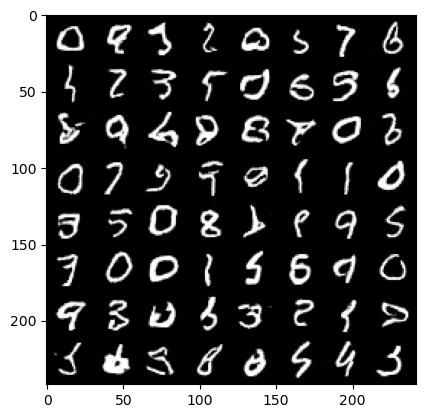

In [18]:
imshow(grid_samples.permute(1,2,0))